In [5]:
# Importing  Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# Setting display
pd.set_option('display.max_columns', None)
# Loading Data
data = pd.read_csv('./train.csv')
# Display few rows 5 of the dataset
print(data.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

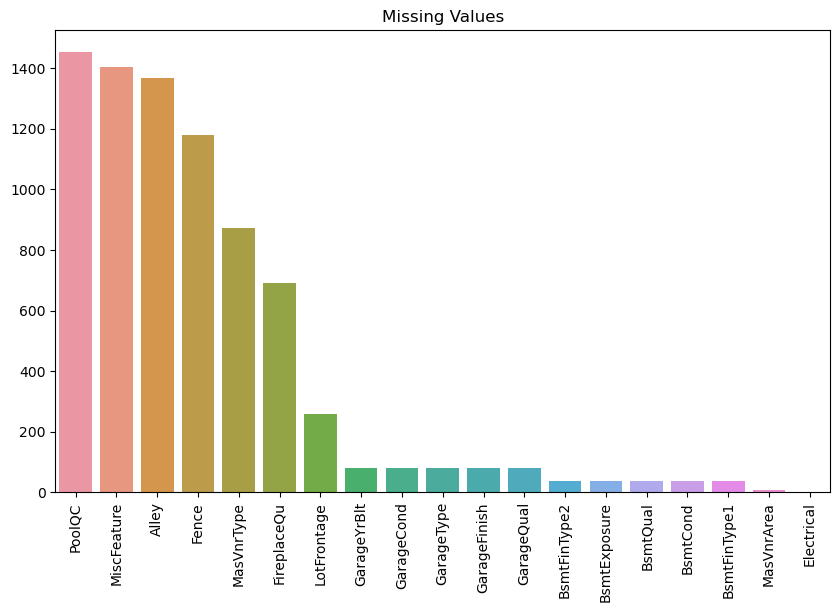

In [8]:

# Check for missing values
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# Visualizing the missing values
plt.figure(figsize=(10,6))
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation=90)
plt.title('Missing Values')
plt.show()


In [9]:
# Handling missing values
data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)

data.drop(columns=missing_values.index[4:], inplace=True)

In [10]:
# Encoding categorical variables and scaling numerical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Remove SalePrice from numeric features as it is the target
numeric_features = numeric_features.drop('SalePrice')

In [12]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

In [13]:
# Splitting the data into training and testing
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Apply PCA to reduce dimensions
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

In [15]:
# Ridge Regression
ridge = Ridge(max_iter=10000)

# Define the parameter grid
param_grid = {'alpha': np.logspace(-3, 3, 7)}

In [16]:
# Grid search (Ridge Regression)
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_pca, y_train)
ridge_best_alpha = ridge_cv.best_params_['alpha']
ridge_best_model = ridge_cv.best_estimator_

In [17]:
# Lasso Regression
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': np.logspace(-3, 3, 7)}

# Grid search (Lasso Regression)
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_pca, y_train)
lasso_best_alpha = lasso_cv.best_params_['alpha']
lasso_best_model = lasso_cv.best_estimator_

In [18]:
# evaluation of Ridge
y_pred_ridge = ridge_best_model.predict(X_test_pca)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2 = r2_score(y_test, y_pred_ridge)

In [19]:
# evaluation of Lasso
y_pred_lasso = lasso_best_model.predict(X_test_pca)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2 = r2_score(y_test, y_pred_lasso)

In [20]:
print(f'Ridge Regression - RMSE: {ridge_rmse}, R2: {ridge_r2}')
print(f'Lasso Regression - RMSE: {lasso_rmse}, R2: {lasso_r2}')

Ridge Regression - RMSE: 35665.15457416584, R2: 0.8341656904230135
Lasso Regression - RMSE: 35145.08795641518, R2: 0.8389667956615987


In [21]:
print(f'Optimal alpha for Ridge: {ridge_best_alpha}')
print(f'Optimal alpha for Lasso: {lasso_best_alpha}')

Optimal alpha for Ridge: 100.0
Optimal alpha for Lasso: 100.0
